# [Деревья решений](https://ru.wikipedia.org/wiki/%D0%94%D0%B5%D1%80%D0%B5%D0%B2%D0%BE_%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D0%B9)

In [1]:
from io import StringIO 
from IPython.display import Image
import graphviz 
import pydotplus
import numpy as np
import pandas as pd
from typing import Dict, Tuple
from sklearn.datasets import load_iris, load_wine, load_boston
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
# Визуализация дерева
def get_png_tree(tree_model_param, feature_names_param):
    dot_data = StringIO()
    export_graphviz(tree_model_param, out_file=dot_data, feature_names=feature_names_param,
                    filled=True, rounded=True, special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph.create_png()

In [3]:
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int, float]:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))

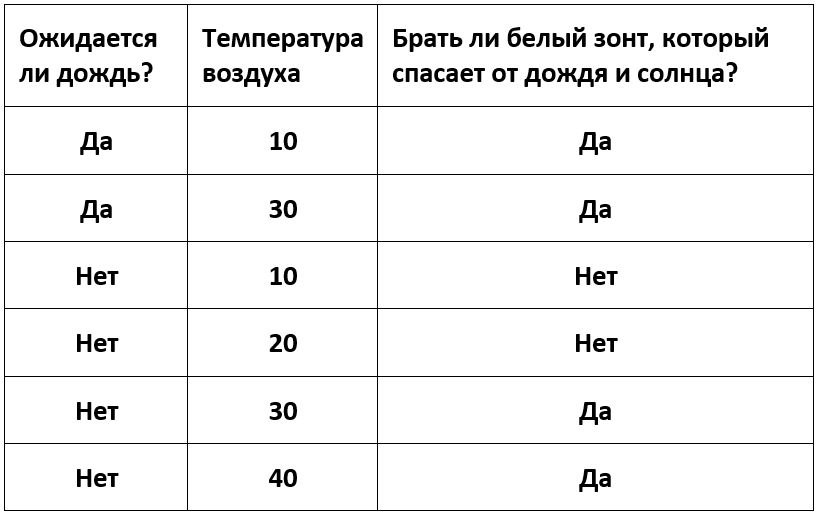

In [4]:
Image("img/dt.png", width="500")

## Метрические и логические методы обучения с учителем

- Метрические методы основаны на построении многомерного пространства числовых признаков, введении метрики в этом пространстве и поиска решения на основе метрики. Классическим примером является KNN. При использовании метрических методов фактически отказываются от специфики предметной области, все признаки превращаются в числовые. Метрические методы, как правило, используют принцип "черного ящика", не поясняют найденное решение в терминах предметной области.

- В противоположность им, логические методы опираются на понятия предметной области. Используется принцип "белого ящика", решение может быть интерпретировано в терминах предметной области. Результатом обучения логического метода  является решение в виде набора правил (формат правил зависит от используемого метода). На этапе предсказания данные тестовой выборки подставляются в сформированные правила, предсказание формируется на основе правил.  


Одним из наиболее простых примеров логических методов являются:
- [Решающие списки.](https://en.wikipedia.org/wiki/Decision_list)
- [Таблицы принятия решений.](https://ru.wikipedia.org/wiki/%D0%A2%D0%B0%D0%B1%D0%BB%D0%B8%D1%86%D0%B0_%D0%BF%D1%80%D0%B8%D0%BD%D1%8F%D1%82%D0%B8%D1%8F_%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D0%B9)

Фактически, на этапе обучения, на основе обучающей выборки составляется "программа" обработки данных обучающей выборки. Проверяемые в этой программе переменные соответствуют признакам (полям) анализируемых данных.

На этапе предсказания в сформированную программу подставляются данные тестовой выборки.

Нельзя не отметить близость логических методов обучения с учителем к алгоритмам, используемым в экспертных системах, в частности, к алгоритму [RETE.](https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_Rete) 

Проверки в решающем списке можно преобразовать в иерархию проверок для отдельных признаков. Это уменьшит временную сложность алгоритма и сделает предсказание более надежным (улучшит обобщающую способность алгоритма). И тогда получится алгоритм обучающего дерева. 

## Математические и алгоритмические основы деревьев решений

### Основной алгоритм построения дерева решения

Фактически, алгоритм построения обучающего дерева, детально описанный [здесь](https://ru.wikipedia.org/wiki/%D0%9E%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B4%D0%B5%D1%80%D0%B5%D0%B2%D0%B0_%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D0%B9), сводится к нескольким пунктам:

* Для текущего выбранного признака (колонки) из N признаков построить все варианты ветвления (разбиения) по значениям (для категориальных признаков) или по диапазонам значений (для числовых признаков). При этом будет сформировано K поддеревьев (где K - число ветвлений). Каждое поддерево содержит подвыборку, которая включает только строки выборки, соответствующие результатам ветвления. В каждом поддереве расположена:

    - или выборка, содержащая N-1 признак, если признак, для которого строится ветвление, полностью пропадает в результате ветвления;
    - или выборка, содержащая N признаков, если признак, для которого строится ветвление, не пропадает полностью в результате ветвления, но при этом число строк в выборке уменьшается;

* Если подвыборке соответствует единственное значение целевого признака, то в дерево добавляется терминальный лист, который соответствует предсказанному значению.
* Если в подвыборке больше одного значения целевого признака, то предыдущие пункты выполняются рекурсивно для подвыборки.

Рассмотрим пример:

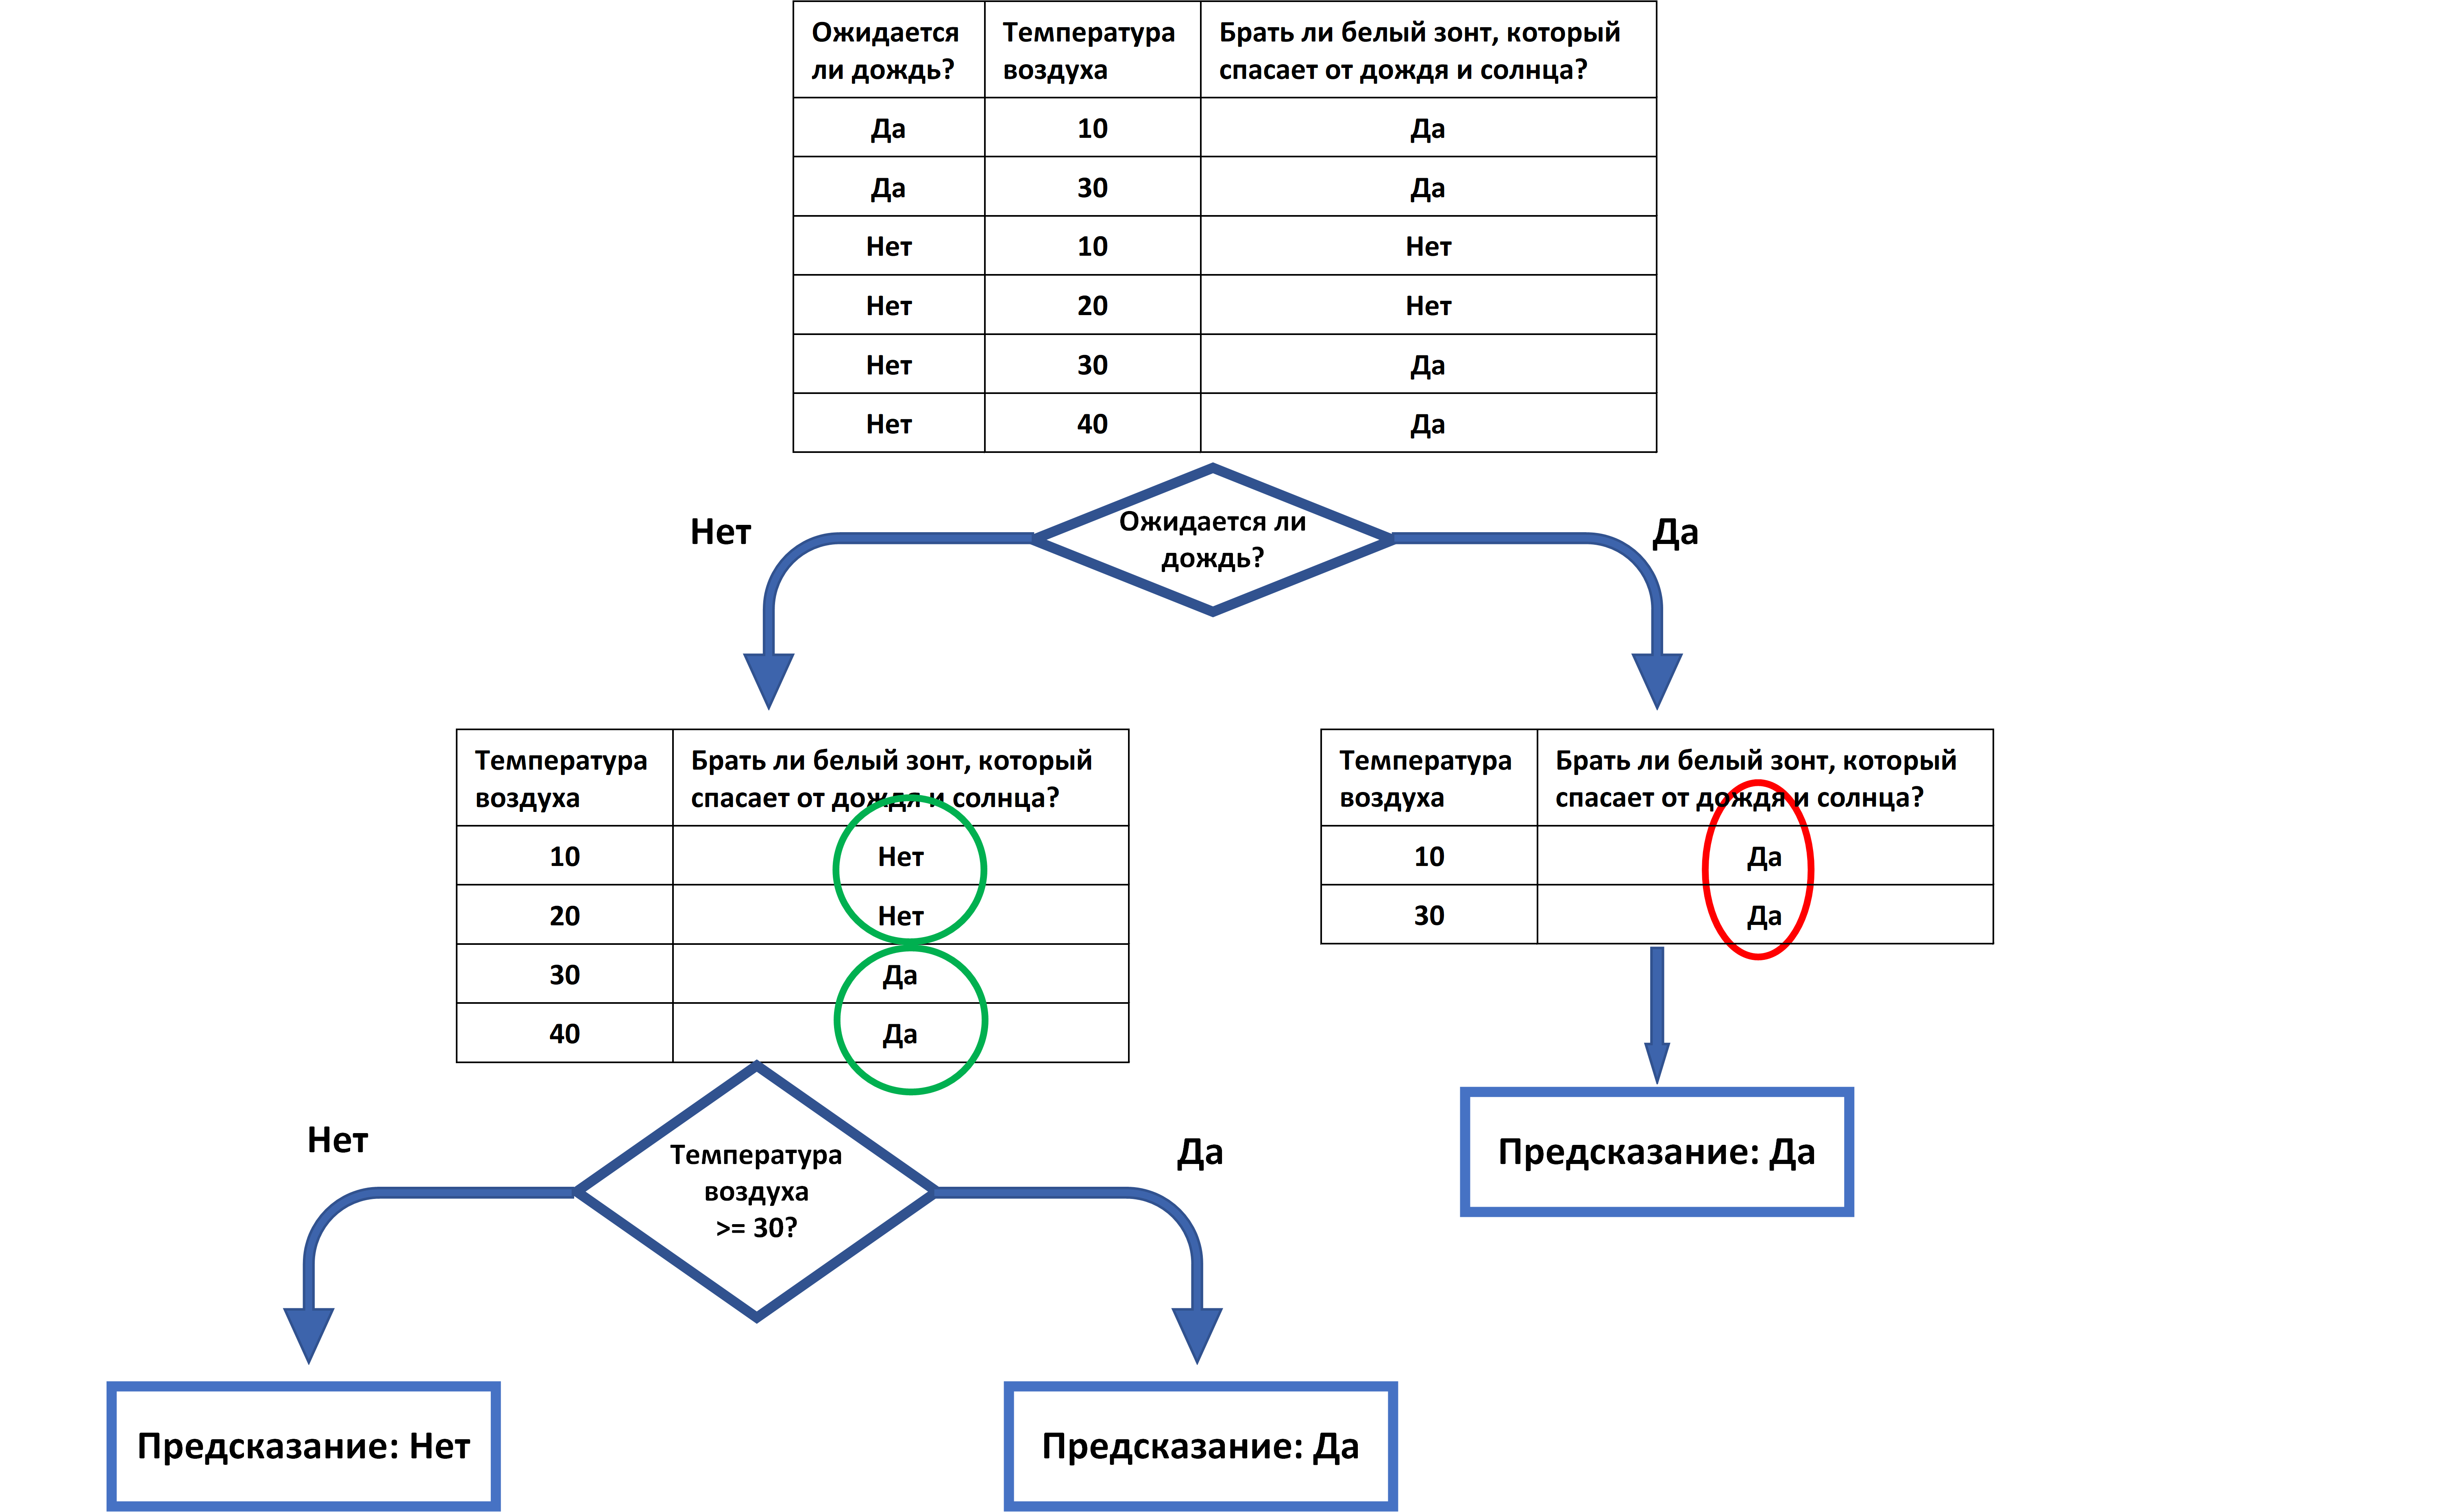

In [5]:
Image('img/dt_tree.png', width='70%')

В экспертной системе правила формируются экспертом в предметной области или на основании известных эксперту теоретических положений [(дедукция)](https://ru.wikipedia.org/wiki/%D0%94%D0%B5%D0%B4%D1%83%D0%BA%D1%82%D0%B8%D0%B2%D0%BD%D0%BE%D0%B5_%D1%83%D0%BC%D0%BE%D0%B7%D0%B0%D0%BA%D0%BB%D1%8E%D1%87%D0%B5%D0%BD%D0%B8%D0%B5) или на основании его личного исчерпывающего опыта принятия решений [(полная индукция.)](https://ru.wikipedia.org/wiki/%D0%98%D0%BD%D0%B4%D1%83%D0%BA%D1%82%D0%B8%D0%B2%D0%BD%D0%BE%D0%B5_%D1%83%D0%BC%D0%BE%D0%B7%D0%B0%D0%BA%D0%BB%D1%8E%D1%87%D0%B5%D0%BD%D0%B8%D0%B5) Дерево решений строит правила на основе обучающей выборки, которая заведомо не может содержать все знания  о предметной области (неполная индукция).

### [Существующие реализации алгоритмов деревьев решений](https://ru.wikipedia.org/wiki/%D0%94%D0%B5%D1%80%D0%B5%D0%B2%D0%BE_%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D0%B9#%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC%D1%8B_%D0%BF%D0%BE%D1%81%D1%82%D1%80%D0%BE%D0%B5%D0%BD%D0%B8%D1%8F_%D0%B4%D0%B5%D1%80%D0%B5%D0%B2%D0%B0)

В библиотеке scikit-learn реализован алгоритм CART. Этот алгоритм предполагает построение бинарного дерева решений. Проверяются условия вида:
- Категориальный признак принимает значение V? - Да, Нет.
- Числовой признак <= значения V? - Да, Нет.

### Выбор текущего признака и текущего разбиения

Основной вопрос состоит в том, как выбирать текущий признак и текущее разбиение на этом признаке. Признак и разбиение  нужно выбирать таким образом, чтобы общее число проверок было минимально.

В случае решения задачи классификации для выбора признака и разбиения используются:
- [Мера неопределенности Джини (Gini impurity)](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity)

- [Энтропийные критерии](https://ru.wikipedia.org/wiki/%D0%98%D0%BD%D1%84%D0%BE%D1%80%D0%BC%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D0%B0%D1%8F_%D1%8D%D0%BD%D1%82%D1%80%D0%BE%D0%BF%D0%B8%D1%8F) 

Меру неопределенности Джини не следует путать с [коэффициентом Джини](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D0%94%D0%B6%D0%B8%D0%BD%D0%B8) который является макроэкономическим показателем.

В случае решения задачи регрессии для проверки используются стандартные регрессионные метрики - MAE, MSE.

### Расчет меры неопределенности Джини для выбора текущего признака

Слово "impurity" можно также переводить как "загрязненность". Если узел дерева содержит единственное значение целевого признака, то он "чист", Gini impurity = 0. 

Если узел дерева содержит несколько значений целевого признака, то значение Gini impurity > 0. Чем ближе значение Gini impurity к нулю, тем лучше.

1. Вначале необходимо рассчитать Gini impurity для всего набора данных.

Это мера того, как часто случайно выбранный элемент будет некорректно классифицирован:

$$ G = \sum\limits_{i=1}^C p_i \sum\limits_{i \ne k} p_k = \sum\limits_{i=1}^C p_i(1-p_i) = \sum\limits_{i=1}^C (p_i-p_i^2) = \sum\limits_{i=1}^C p_i - \sum\limits_{i=1}^C p_i^2 = 1 - \sum\limits_{i=1}^C p_i^2, $$

где:

- $C$ - количество классов;
- $p_i$ - вероятность i-го значения целевого признака, отношение количества записей с целевым признаком i к общему количеству записей.


2. Далее необходимо рассчитать Gini impurity для новых выборок, которые получаются в результате разделения. Если произошло бинарное разделение на левую (L) и правую (R) ветви, и N - доля записей, то текущий остаток :

$$ G_{rem} = G_L N_L + G_R N_R $$

Или для случая j разделений:

$$ G_{rem} = \sum\limits_{j} G_j N_j $$

3. Далее расчитывается Gini gain: 

$$ G_{gain} = G - G_{rem} $$

Чем больше $G_{gain}$, тем лучше разделение.

Пункты 1-3 необходимо повторить для каждого признака и выбрать для разделения признак с лучшим значением $G_{gain}$.

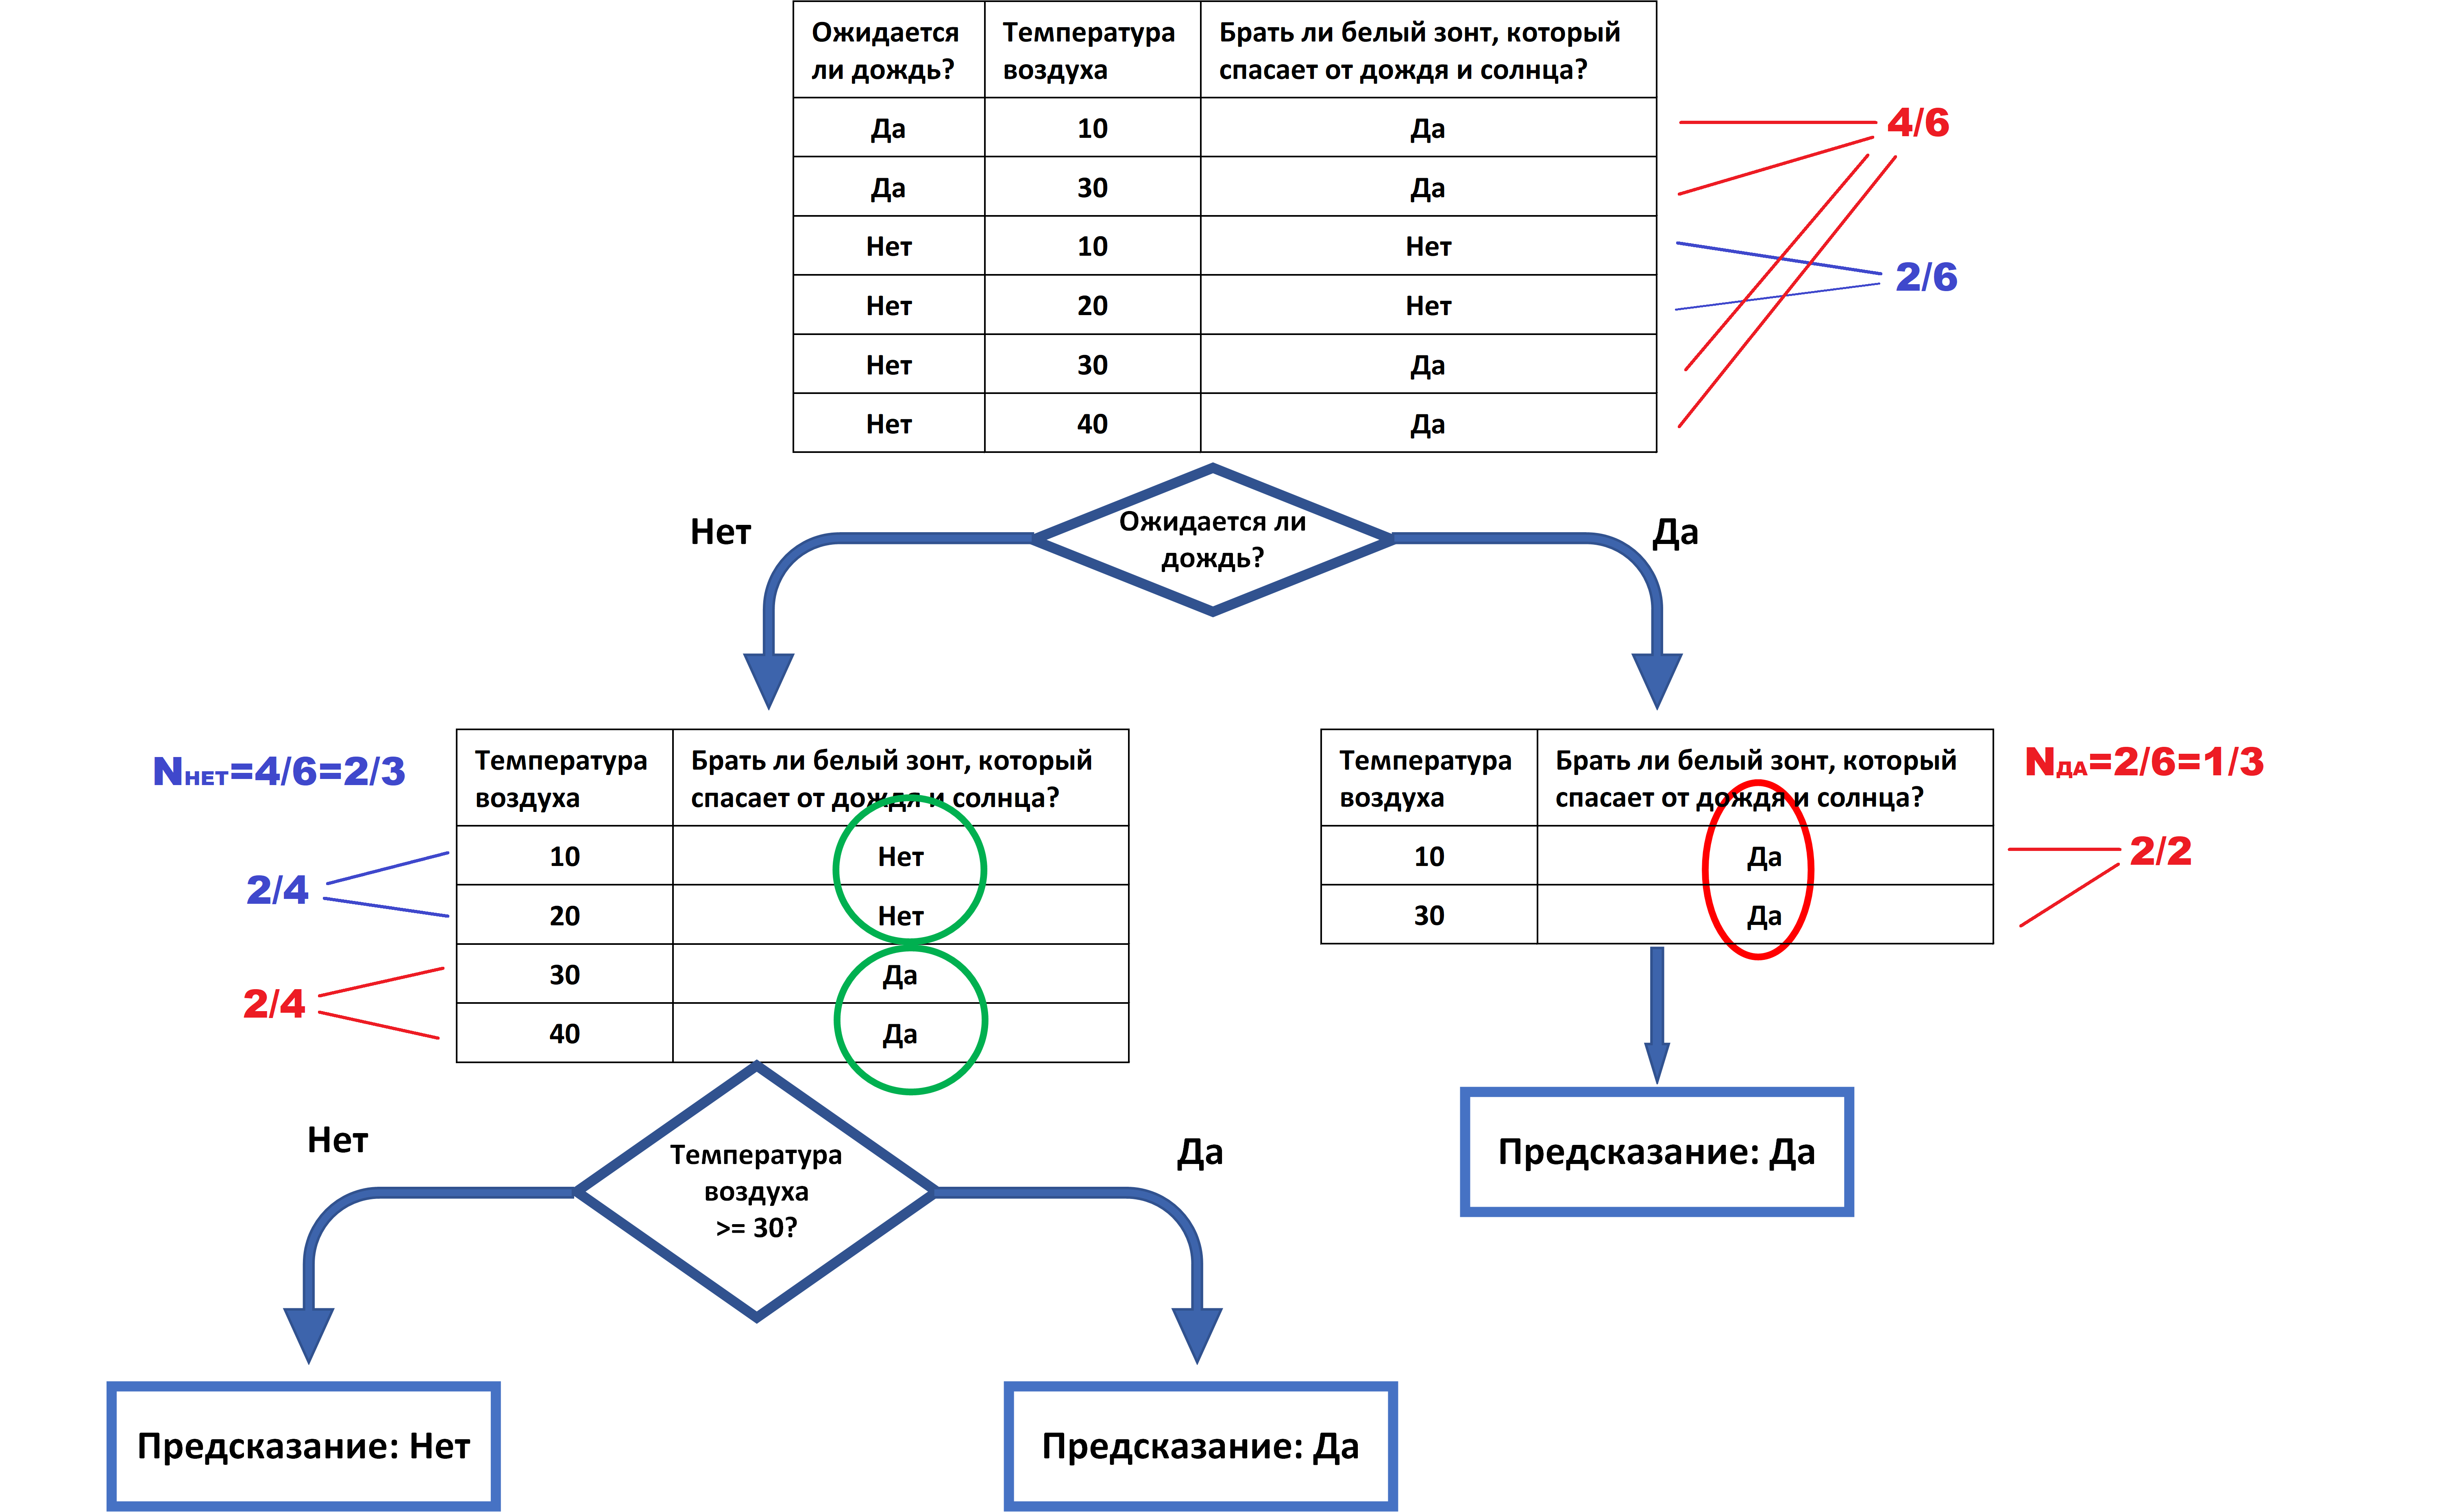

In [6]:
Image('img/dt_tree_gini.png', width='70%')

Рассчитаем неопределенность Джини для первого разделения нашего набора данных по признаку "Ожидается ли дождь?":

$$p_{Да} = 4/6$$
$$p_{Нет} = 2/6$$

$$ G = 1 - \sum\limits_{i=1}^C p_i^2 = 1 - ( p_{Да}^2 + p_{Нет}^2 ) = 1 - ((4/6)^2 + (2/6)^2) = 0,444 $$

Рассчитаем значения для правой ветви:

$$ G_{Да} = 1 - ((2/2)^2 + (0)^2) = 0 $$
$$N_{Да} = 1/3 $$

Рассчитаем значения для левой ветви:

$$ G_{Нет} = 1 - ((2/4)^2 + (2/4)^2) = 0,5 $$
$$N_{Нет} = 2/3 $$

Рассчитаем Gini gain:

$$ G_{rem} = G_{Да} \cdot N_{Да} + G_{Нет} \cdot N_{Нет} = 0 \cdot 1/3 + 0,5 \cdot 2/3 = 0,333 $$

$$ G_{gain} = G - G_{rem} = 0,444 - 0,333 = 0,111 $$

Такие расчеты необходимо было бы проверсти для каждого признака и выбрать для разделения признак, которому соответствует максимальный $G_{gain}$.

Возможно использование [других критериев](https://scikit-learn.org/stable/modules/tree.html#mathematical-formulation) но на общий принцип это не влияет. 

Данный пример содержит небольшое количество признаков. О общем случае алгоритм является рекурсивным, один признак может несколько раз участвовать в принятии решения.

### Как быть с числовыми признаками?

В отличие от категориальных признаков, числовой признак является действительным числом. То есть, количество возможных разбиений бесконечно. 

Разбиение производится на основе порогов. Узел бинарного дерева строится на основе правил:
- ЕСЛИ значение <= порога ТО ИСТИНА
- ИНАЧЕ ЕСЛИ значение > порога ТО ЛОЖЬ

Пороги, как правило, выбираются на основе жадного алгоритма и могут совпадать со значениями признака или располагаться между значениями признака.

### Работа с пропусками

Для предсказания данных, содержащих пропущенные значения, в деревьях решений используется следующий подход:

- Когда достигается узел дерева, содержащий проверку пропущенного значения, то поиск продолжается независимо по всем ветвям дерева вниз. Получается несколько предсказаний.
- В хорошем случае предсказания могут совпасть.
- В противном случае оценивается количество записей обучающей выборки, которое поддерживает данное предсказание. Выбирается предсказание с наибольшим количеством записей.

**Текущая версия библиотеки scikit-learn не поддерживает работу с пропусками. Пропущенные значения необходимо предварительно заполнять вручную.**

### [Преимущества деревьев решений](https://ru.wikipedia.org/wiki/%D0%94%D0%B5%D1%80%D0%B5%D0%B2%D0%BE_%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D0%B9#%D0%94%D0%BE%D1%81%D1%82%D0%BE%D0%B8%D0%BD%D1%81%D1%82%D0%B2%D0%B0_%D0%BC%D0%B5%D1%82%D0%BE%D0%B4%D0%B0)
- Работают по принципу "белого ящика". Логика построенного дерева хорошо отображается на исследуемую предметную область. 
- Можно визуализировать алгоритм в виде дерева.
- Требуют мало данных для обучения.
- Работает с числовыми и категориальными признаками. *В настоящее время scikit-learn требует кодирования категориальных признаков с использованием LabelEncoder.*

### [Недостатки деревьев решений](https://ru.wikipedia.org/wiki/%D0%94%D0%B5%D1%80%D0%B5%D0%B2%D0%BE_%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D0%B9#%D0%9D%D0%B5%D0%B4%D0%BE%D1%81%D1%82%D0%B0%D1%82%D0%BA%D0%B8_%D0%BC%D0%B5%D1%82%D0%BE%D0%B4%D0%B0)
- Могут переобучаться. Для борьбы с переобучением используется [регулирование глубины дерева](https://ru.wikipedia.org/wiki/%D0%94%D0%B5%D1%80%D0%B5%D0%B2%D0%BE_%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D0%B9#%D0%A0%D0%B5%D0%B3%D1%83%D0%BB%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BB%D1%83%D0%B1%D0%B8%D0%BD%D1%8B_%D0%B4%D0%B5%D1%80%D0%B5%D0%B2%D0%B0) или "cтрижка" дерева. Англ. [decision_tree_pruning.](https://en.wikipedia.org/wiki/Decision_tree_pruning)
- Очень сильно зависят от набора данных в обучающей выборке. Появление одного нового примера может полностью перестроить весь каскад условий. Однако, на этом недостатке построено использование дерева в ансамблевых классификаторах, поэтому в ансамблях на основе деревьев данный недостаток можно рассматривать как достоинство.

## [Реализация деревьев решений в библиотеке scikit-learn](https://scikit-learn.org/stable/modules/tree.html)

### Решение задачи классификации

Для решения задачи классификации используется класс [DecisionTreeClassifier.](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

In [7]:
# Используем датасеты для классификации
iris = load_iris()
wine = load_wine()
iris_x_ds = pd.DataFrame(data=iris['data'], columns=iris['feature_names'])
iris_x_ds.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2

In [8]:
def plot_tree_classification(title_param, ds):
    """
    Построение деревьев и вывод графиков для заданного датасета
    """
    
    n_classes = len(np.unique(ds.target))
    plot_colors = "ryb"
    plot_step = 0.02
    
    for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                    [1, 2], [1, 3], [2, 3]]):
        # We only take the two corresponding features
        X = ds.data[:, pair]
        y = ds.target

        # Train
        clf = DecisionTreeClassifier(random_state=1).fit(X, y)

        plt.title(title_param)

        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))
        plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

        plt.xlabel(ds.feature_names[pair[0]])
        plt.ylabel(ds.feature_names[pair[1]])

        # Plot the training points
        for i, color in zip(range(n_classes), plot_colors):
            idx = np.where(y == i)
            plt.scatter(X[idx, 0], X[idx, 1], c=color, label=ds.target_names[i],
                        cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

        plt.show()    
    

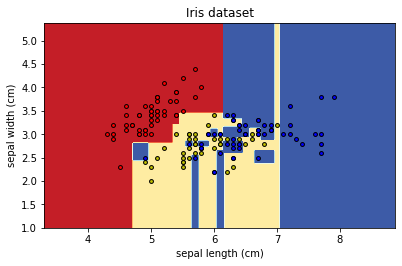

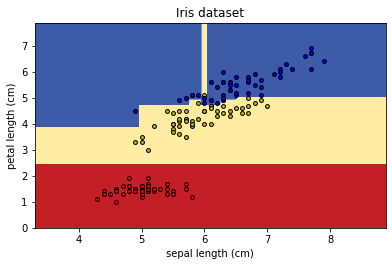

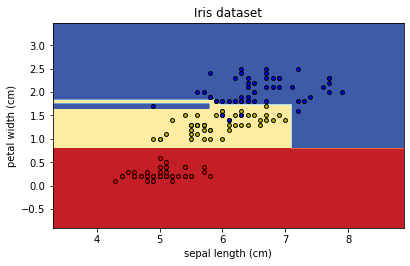

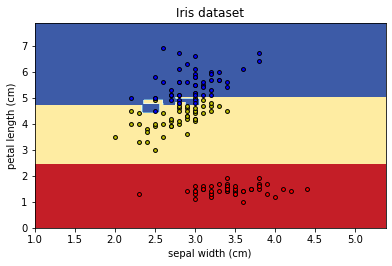

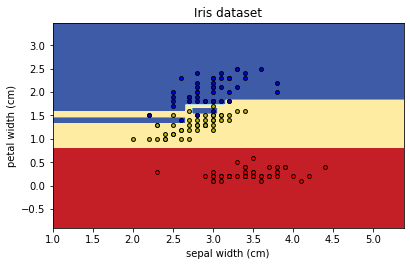

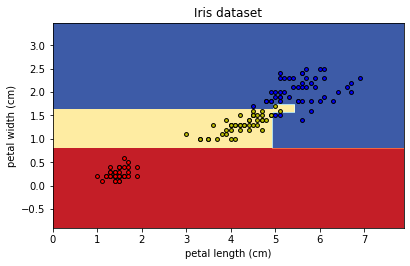

In [9]:
plot_tree_classification('Iris dataset', iris)

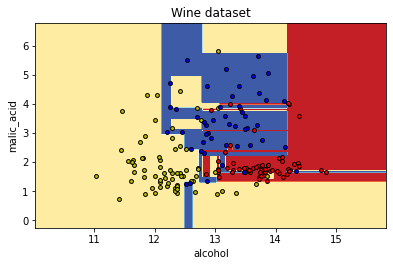

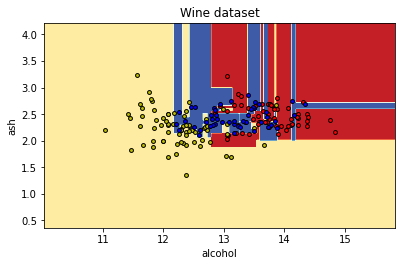

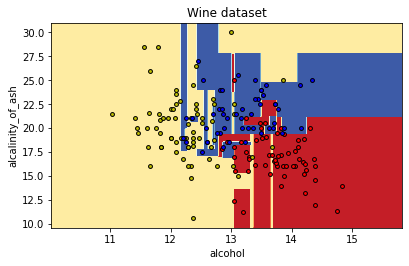

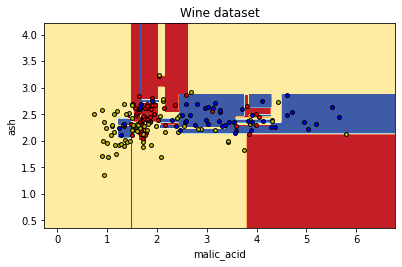

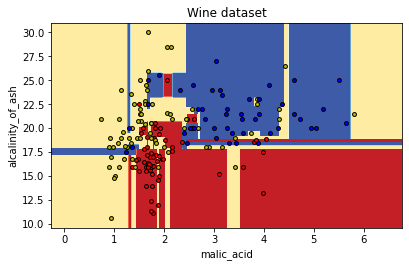

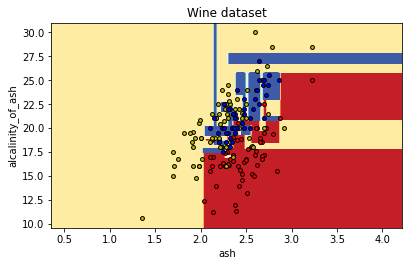

In [10]:
plot_tree_classification('Wine dataset', wine)

In [11]:
# Обучим дерево на всех признаках iris
iris_tree_cl = DecisionTreeClassifier(random_state=1)
iris_tree_cl.fit(iris_x_ds, iris.target)
iris_tree_cl

DecisionTreeClassifier(random_state=1)

### Вывод правил дерева в текстовом виде

Корректно работает в консоли. В ячейке ноутбука форматируется некорректно.

[Пример работы](https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_text.html) в библиотеке scikit-learn.

In [12]:
from IPython.core.display import HTML
from sklearn.tree import export_text
tree_rules = export_text(iris_tree_cl, feature_names=list(iris_x_ds.columns))
HTML('<pre>' + tree_rules + '</pre>')

### Пример визуализации дерева

Для визуализации необходимо :
1. установить на компьютер программную библиотеку [Graphviz](https://ru.wikipedia.org/wiki/Graphviz)
1. установить питоновский пакет graphviz - "conda install python-graphviz"
1. установить питоновский пакет pydotplus - "conda install pydotplus"

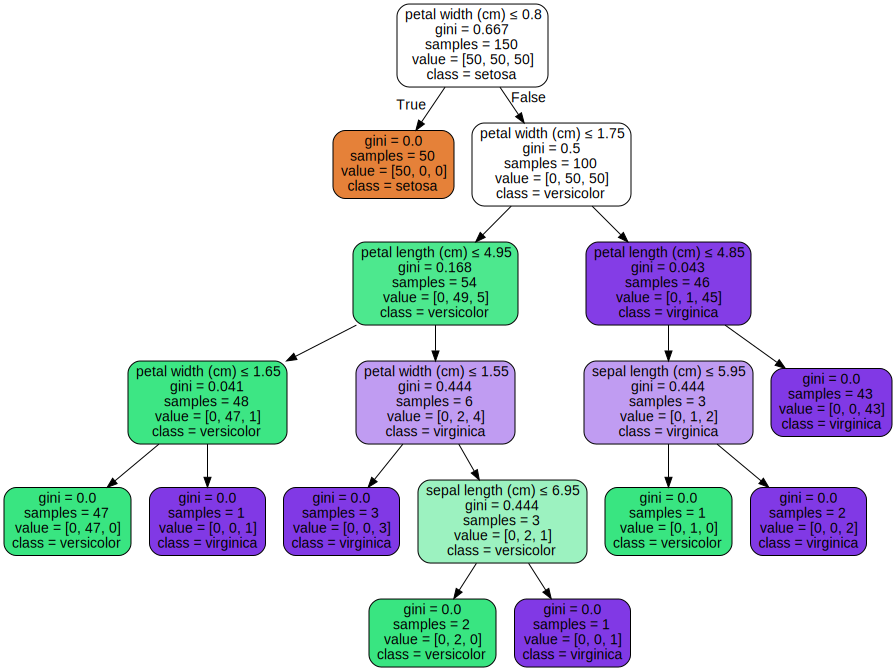

In [13]:
dot_data = export_graphviz(iris_tree_cl, out_file=None, 
                           feature_names=iris.feature_names, 
                           class_names=iris.target_names, 
                           filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

### Важность признаков

С помощью свойства feature_importances_ можно получить значение важности признаков.

Вычисление важности признаков основано на том, какое количество раз признак встречается в условиях дерева. Чем чаще встречается признак, тем более он важен.

In [14]:
# Важность признаков
list(zip(iris_x_ds.columns.values, iris_tree_cl.feature_importances_))

[('sepal length (cm)', 0.026666666666666658),
 ('sepal width (cm)', 0.0),
 ('petal length (cm)', 0.05072262479871173),
 ('petal width (cm)', 0.9226107085346216)]

In [15]:
# Важность признаков в сумме дает единицу
sum(iris_tree_cl.feature_importances_)

1.0

In [16]:
from operator import itemgetter

def draw_feature_importances(tree_model, X_dataset, figsize=(18,5)):
    """
    Вывод важности признаков в виде графика
    """
    # Сортировка значений важности признаков по убыванию
    list_to_sort = list(zip(X_dataset.columns.values, tree_model.feature_importances_))
    sorted_list = sorted(list_to_sort, key=itemgetter(1), reverse = True)
    # Названия признаков
    labels = [x for x,_ in sorted_list]
    # Важности признаков
    data = [x for _,x in sorted_list]
    # Вывод графика
    fig, ax = plt.subplots(figsize=figsize)
    ind = np.arange(len(labels))
    plt.bar(ind, data)
    plt.xticks(ind, labels, rotation='vertical')
    # Вывод значений
    for a,b in zip(ind, data):
        plt.text(a-0.05, b+0.01, str(round(b,3)))
    plt.show()
    return labels, data

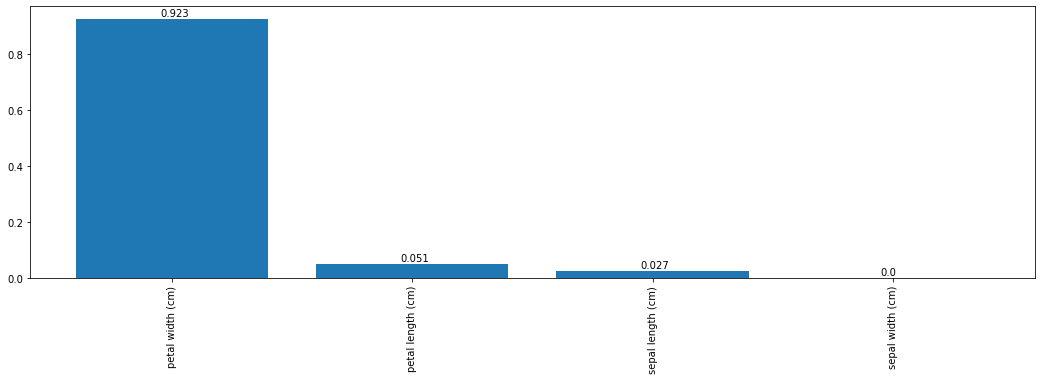

In [17]:
iris_tree_cl_fl, iris_tree_cl_fd = draw_feature_importances(iris_tree_cl, iris_x_ds)

In [18]:
# Список признаков, отсортированный на основе важности, и значения важности
iris_tree_cl_fl, iris_tree_cl_fd

(['petal width (cm)',
  'petal length (cm)',
  'sepal length (cm)',
  'sepal width (cm)'],
 [0.9226107085346216, 0.05072262479871173, 0.026666666666666658, 0.0])

In [19]:
iris_x_ds.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2

In [20]:
# Пересортируем признаки на основе важности
iris_x_ds_sorted = iris_x_ds[iris_tree_cl_fl]
iris_x_ds_sorted.head()

petal width (cm)  petal length (cm)  sepal length (cm)  sepal width (cm)
0               0.2                1.4                5.1               3.5
1               0.2                1.4                4.9               3.0
2               0.2                1.3                4.7               3.2
3               0.2                1.5                4.6               3.1
4               0.2                1.4                5.0               3.6

In [21]:
# Разделим выборку на обучающую и тестовую
iris_X_train, iris_X_test, iris_y_train, iris_y_test = train_test_split(
    iris_x_ds_sorted, iris.target, test_size=0.5, random_state=1)
iris_X_train.shape, iris_X_test.shape

((75, 4), (75, 4))

In [22]:
# Обучим дерево и предскажем результаты на всех признаках 
iris_tree_cl_feat_1 = DecisionTreeClassifier(random_state=1).fit(iris_X_train, iris_y_train)
iris_y_test_predict = iris_tree_cl_feat_1.predict(iris_X_test)
iris_y_test_predict.shape

(75,)

In [23]:
# Проверим точность по классам
print_accuracy_score_for_classes(iris_y_test, iris_y_test_predict)

Метка 	 Accuracy
0 	 1.0
1 	 1.0
2 	 0.7777777777777778


In [24]:
# Обучим дерево и предскажем результаты на единственном самом важном признаке 
iris_tree_cl_feat_2 = DecisionTreeClassifier(random_state=1).fit(iris_X_train[[iris_tree_cl_fl[0]]], iris_y_train)
iris_y_test_predict_2 = iris_tree_cl_feat_2.predict(iris_X_test[[iris_tree_cl_fl[0]]])
iris_y_test_predict_2.shape

(75,)

In [25]:
# Проверим точность по классам
print_accuracy_score_for_classes(iris_y_test, iris_y_test_predict_2)

Метка 	 Accuracy
0 	 1.0
1 	 0.9583333333333334
2 	 0.9629629629629629


### Решение задачи регрессии

Для решения задачи регрессии используется класс [DecisionTreeRegressor.](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)

При решении задачи регрессии производится аппроксимация кусочно-линейной функцией.

In [26]:
def random_dataset_for_regression():
    """
    Создание случайного набора данных для регрессии
    """
    rng = np.random.RandomState(1)
    X_train = np.sort(5 * rng.rand(80, 1), axis=0)
    y_train = np.sin(X_train).ravel()
    y_train[::5] += 3 * (0.5 - rng.rand(16))
    X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
    return X_train, y_train, X_test

In [27]:
def plot_tree_regression(X_train, y_train, X_test):
    """
    Построение деревьев и вывод графиков для заданного датасета
    """

    # Обучение регрессионной модели
    regr_1 = DecisionTreeRegressor(max_depth=3)
    regr_2 = DecisionTreeRegressor(max_depth=10)
    regr_1.fit(X_train, y_train)
    regr_2.fit(X_train, y_train)

    # Предсказание
    y_1 = regr_1.predict(X_test)
    y_2 = regr_2.predict(X_test)

    # Вывод графика
    fig, ax = plt.subplots(figsize=(15,7))
    plt.scatter(X_train, y_train, s=20, edgecolor="black", c="darkorange", label="Данные")
    plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth=3", linewidth=2)
    plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=10", linewidth=2)
    plt.xlabel("Данные")
    plt.ylabel("Целевой признак")
    plt.title("Регрессия на основе дерева решений")
    plt.legend()
    plt.show()

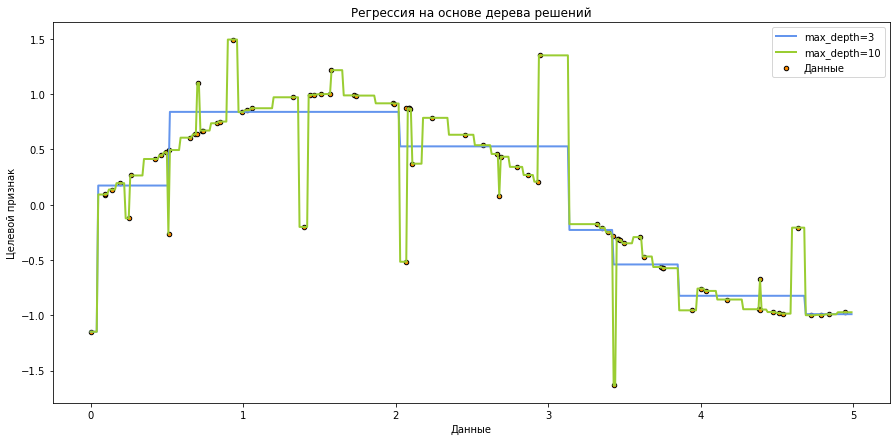

In [28]:
X_train, y_train, X_test = random_dataset_for_regression()
plot_tree_regression(X_train, y_train, X_test)

In [29]:
boston = load_boston()
df_boston = pd.DataFrame(boston.data,columns=boston.feature_names)
df_boston.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  
0     15.3  396.90   4.98  
1     17.8  396.90   9.14  
2     17.8  392.83   4.03  
3     18.7  394.63   2.94  
4     18.7  396.90   5.33

In [30]:
# Обучим дерево на всех признаках boston
boston_tree_regr = DecisionTreeRegressor(random_state=1)
boston_tree_regr.fit(df_boston, boston.target)
boston_tree_regr

DecisionTreeRegressor(random_state=1)

In [31]:
Image(get_png_tree(boston_tree_regr, df_boston.columns), height='100%')

In [32]:
# Обучим дерево на всех признаках boston c ограничением глубины дерева
boston_tree_regr_prun = DecisionTreeRegressor(random_state=1, max_depth=3)
boston_tree_regr_prun.fit(df_boston, boston.target)
boston_tree_regr_prun

DecisionTreeRegressor(max_depth=3, random_state=1)

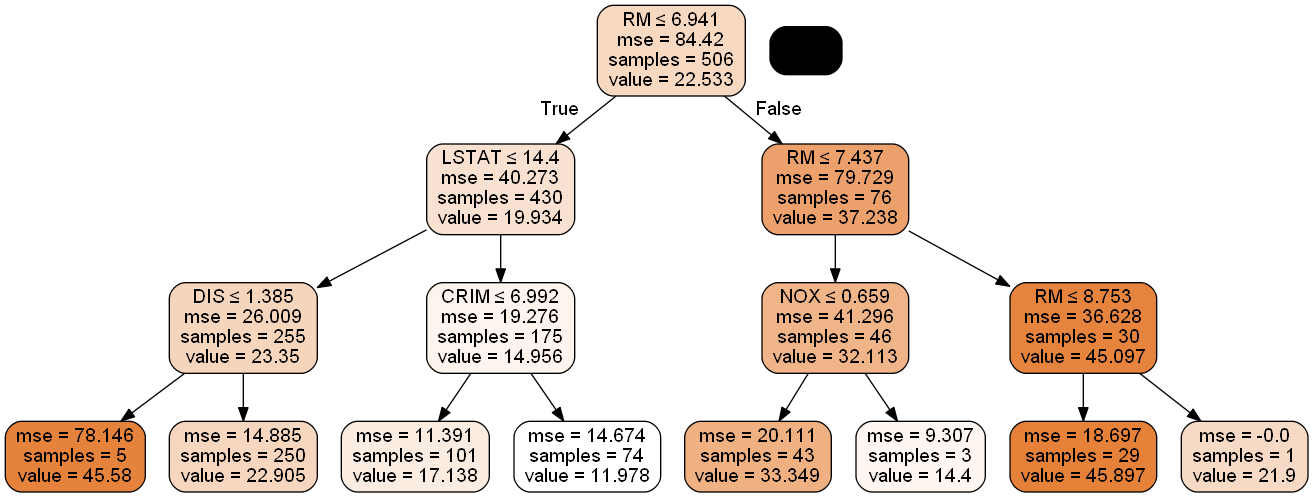

In [33]:
Image(get_png_tree(boston_tree_regr_prun, df_boston.columns), height='70%')

In [34]:
sum(boston_tree_regr.feature_importances_)

1.0

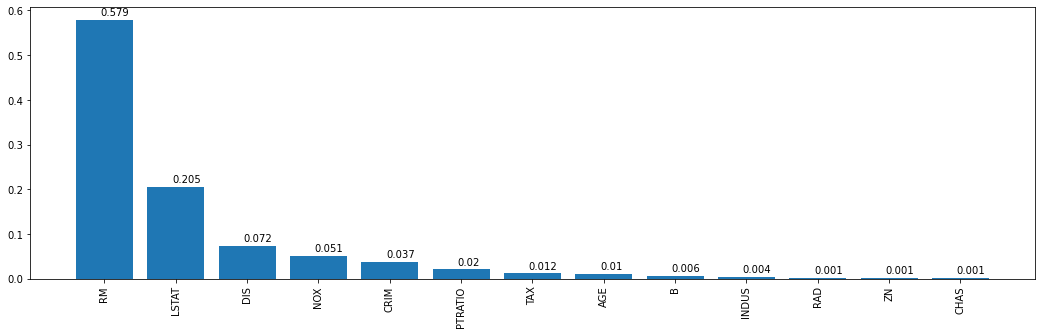

In [35]:
boston_tree_regr_fl, boston_tree_regr_fd = draw_feature_importances(boston_tree_regr, df_boston)

In [36]:
boston_tree_regr_fl[0:5]

['RM', 'LSTAT', 'DIS', 'NOX', 'CRIM']

In [37]:
sum(boston_tree_regr_fd[0:5])

0.944540695391447

In [38]:
df_boston.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  
0     15.3  396.90   4.98  
1     17.8  396.90   9.14  
2     17.8  392.83   4.03  
3     18.7  394.63   2.94  
4     18.7  396.90   5.33

In [39]:
# Пересортируем признаки на основе важности
df_boston_sorted = df_boston[boston_tree_regr_fl]
df_boston_sorted.head()

RM  LSTAT     DIS    NOX     CRIM  PTRATIO    TAX   AGE       B  INDUS  \
0  6.575   4.98  4.0900  0.538  0.00632     15.3  296.0  65.2  396.90   2.31   
1  6.421   9.14  4.9671  0.469  0.02731     17.8  242.0  78.9  396.90   7.07   
2  7.185   4.03  4.9671  0.469  0.02729     17.8  242.0  61.1  392.83   7.07   
3  6.998   2.94  6.0622  0.458  0.03237     18.7  222.0  45.8  394.63   2.18   
4  7.147   5.33  6.0622  0.458  0.06905     18.7  222.0  54.2  396.90   2.18   

   RAD    ZN  CHAS  
0  1.0  18.0   0.0  
1  2.0   0.0   0.0  
2  2.0   0.0   0.0  
3  3.0   0.0   0.0  
4  3.0   0.0   0.0

In [40]:
# Разделение данных на обучающую и тестовую выборки
boston_X_train, boston_X_test, boston_y_train, boston_y_test = train_test_split(
    df_boston_sorted, boston.target, test_size=0.3, random_state=1)

In [41]:
boston_X_train.shape, boston_X_test.shape

((354, 13), (152, 13))

In [42]:
# Обучим дерево и предскажем результаты на всех признаках 
boston_tree_regr_feat_1 = DecisionTreeRegressor(random_state=1).fit(boston_X_train, boston_y_train)
boston_y_test_predict = boston_tree_regr_feat_1.predict(boston_X_test)
boston_y_test_predict.shape

(152,)

In [43]:
mean_absolute_error(boston_y_test, boston_y_test_predict)

2.877631578947368

In [44]:
# Обучим дерево и предскажем результаты на пяти лучших признаках 
boston_tree_regr_feat_2 = DecisionTreeRegressor(random_state=1).fit(
    boston_X_train[boston_tree_regr_fl[0:5]], boston_y_train)
boston_y_test_predict_2 = boston_tree_regr_feat_2.predict(boston_X_test[boston_tree_regr_fl[0:5]])
boston_y_test_predict_2.shape

(152,)

In [45]:
# Ошибка стала меньше
mean_absolute_error(boston_y_test, boston_y_test_predict_2)

2.7453947368421048

In [46]:
# Исследуем, как изменяется ошибка при добавлении признаков в порядке значимости
boston_X_range = list(range(1, len(boston_X_train.columns)+1))
boston_X_range

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [47]:
mae_list = []
for i in boston_X_range:
    # Обучим дерево и предскажем результаты на заданном количестве признаков 
    boston_tree_regr_feat_3 = DecisionTreeRegressor(random_state=1).fit(
        boston_X_train[boston_tree_regr_fl[0:i]], boston_y_train)
    boston_y_test_predict_3 = boston_tree_regr_feat_3.predict(boston_X_test[boston_tree_regr_fl[0:i]])
    temp_mae = mean_absolute_error(boston_y_test, boston_y_test_predict_3)
    mae_list.append(temp_mae)

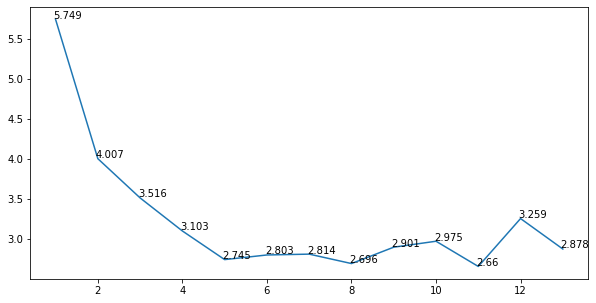

In [48]:
plt.subplots(figsize=(10,5))
plt.plot(boston_X_range, mae_list)
for a,b in zip(boston_X_range, mae_list):
    plt.text(a-0.05, b+0.01, str(round(b,3)))
plt.show()

### Гиперпараметры и борьба с переобучением

В линейной регресии косвенным признаком переобучения были большие абсолютные значения коэффициентов регресии. 

В решающих деревьях таким же косвенным признаком является глубина дерева. Для борьбы с перебучением применяют сокращение глубины дерева или "стрижку дерева" (tree pruning). В библиотеке scikit-learn используется подход "Cost complexity pruning", стрижка производится [на основе использования параметра ccp_alpha](https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning) а детали [рассматривается в примере.](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html) Пошаговый [пример работы алгоритма.](http://mlwiki.org/index.php/Cost-Complexity_Pruning)


На практике для улучшения качества работы алгоритма используется подбор гиперпараметров на основе кросс-валидации. Гиперпараметры описаны в документации классов:
- [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
- [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)

Рассмотрим пример подбора гиперпараметров для обучающего дерева:

In [49]:
params = {
    'max_depth': [3, 4, 5, 6],
    'min_samples_leaf': [0.04, 0.06, 0.08],
    'max_features': [0.2, 0.4, 0.6, 0.8]
}

In [50]:
%%time
grid_1 = GridSearchCV(estimator=DecisionTreeRegressor(random_state=1),
                    param_grid=params, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1)
grid_1.fit(df_boston, boston.target)

Wall time: 4.22 s


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6],
                         'max_features': [0.2, 0.4, 0.6, 0.8],
                         'min_samples_leaf': [0.04, 0.06, 0.08]},
             scoring='neg_mean_absolute_error')

In [51]:
%%time
grid_2 = GridSearchCV(estimator=DecisionTreeRegressor(random_state=1),
                    param_grid=params, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
grid_2.fit(df_boston, boston.target)

Wall time: 218 ms


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6],
                         'max_features': [0.2, 0.4, 0.6, 0.8],
                         'min_samples_leaf': [0.04, 0.06, 0.08]},
             scoring='neg_mean_squared_error')

In [52]:
-grid_1.best_score_, grid_1.best_params_

(3.926892662935901,
 {'max_depth': 4, 'max_features': 0.6, 'min_samples_leaf': 0.06})

In [53]:
-grid_2.best_score_, grid_2.best_params_

(32.18077135293171,
 {'max_depth': 4, 'max_features': 0.6, 'min_samples_leaf': 0.06})

## Дополнительные источники

- [Деревья решений — общие принципы работы](https://basegroup.ru/community/articles/description)
- [Текст лекции профессора К.В. Воронцова](http://www.machinelearning.ru/wiki/images/3/3e/Voron-ML-Logic.pdf)
- [Презентация к лекции](http://www.machinelearning.ru/wiki/images/9/97/Voron-ML-Logic-slides.pdf) профессора К.В. Воронцова
- [Открытый курс машинного обучения. Лекция по деревьям решений](https://habr.com/ru/company/ods/blog/322534/)
- [Реализация алгоритма CART на языке Python](https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/)